# **RNN Study**

### Scaling Plot

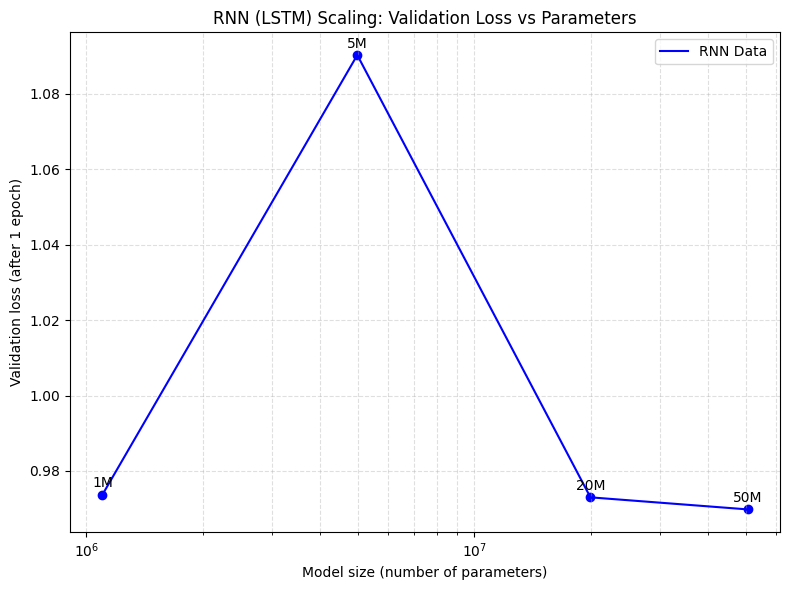

In [11]:
import numpy as np
import matplotlib.pyplot as plt

N = np.array([1.10e6, 4.99e6, 1.99e7, 5.06e7])
val_loss = np.array([0.9737, 1.0903, 0.9730, 0.9698])
labels = ["1M", "5M", "20M", "50M"]

plt.figure(figsize=(8, 6))
plt.scatter(N, val_loss, color='blue')
plt.plot(N, val_loss, color='blue', label='RNN Data')

for i, label in enumerate(labels):
    plt.text(
        N[i],
        val_loss[i] + 0.002,
        label,
        fontsize=10,
        ha='center'
    )

plt.xscale('log')
plt.xlabel("Model size (number of parameters)")
plt.ylabel("Validation loss (after 1 epoch)")
plt.title("RNN (LSTM) Scaling: Validation Loss vs Parameters")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


We can see from the plot that there is no clear power-law behaviour.

### Comparison Plot: Transformer vs RNN

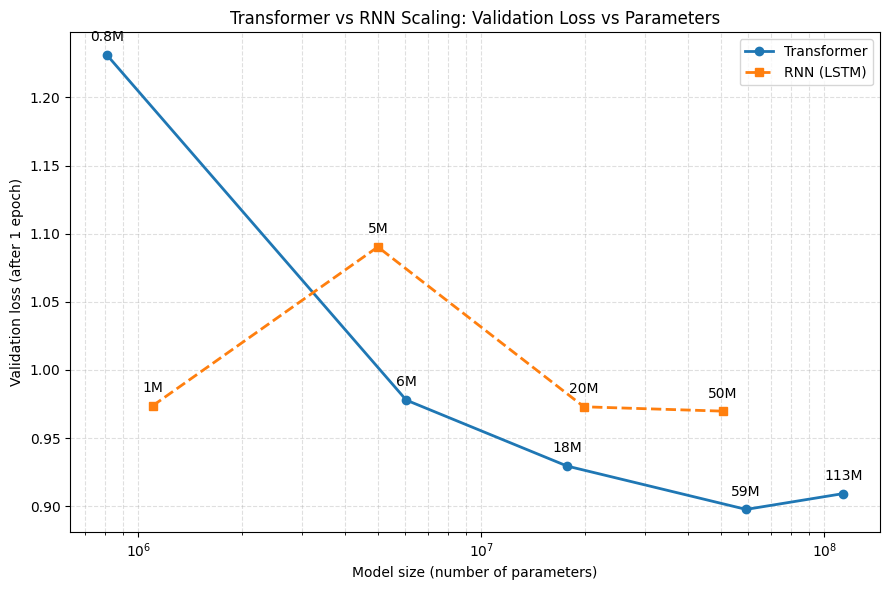

In [14]:
import numpy as np
import matplotlib.pyplot as plt

N_tf = np.array([
    0.81e6,    
    6.04e6,    
    17.78e6,    
    59.12e6,   
    113.42e6   
])

val_tf = np.array([
    1.2311,  
    0.9779,  
    0.9295,  
    0.8977,  
    0.9093   
])

labels_tf = ["0.8M", "6M", "18M", "59M", "113M"]

N_rnn = np.array([1.10e6, 4.99e6, 1.99e7, 5.06e7])
val_rnn = np.array([0.9737, 1.0903, 0.9730, 0.9698])
labels_rnn = ["1M", "5M", "20M", "50M"]

plt.figure(figsize=(9, 6))

plt.plot(N_tf, val_tf, 'o-', label='Transformer', linewidth=2)

plt.plot(N_rnn, val_rnn, 's--', label='RNN (LSTM)', linewidth=2)

for x, y, lab in zip(N_tf, val_tf, labels_tf):
    plt.text(x, y + 0.01, lab, ha='center', fontsize=10)

for x, y, lab in zip(N_rnn, val_rnn, labels_rnn):
    plt.text(x, y + 0.01, lab, ha='center', fontsize=10)

plt.xscale('log')
plt.xlabel("Model size (number of parameters)")
plt.ylabel("Validation loss (after 1 epoch)")
plt.title("Transformer vs RNN Scaling: Validation Loss vs Parameters")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


# **Part 3 — RNN Scaling Study and Comparison**

### **RNN Scaling Experiment**

In order to analyse scaling behaviour for recurrent architectures, I trained four LSTM-based language models with parameter counts approximately matching the ones utilised in the prior transformer models: **1M, 5M, 20M, and 50M parameters**. All models were trained under the exact same conditions as the transformer scaling study: one epoch over 100M tokens, identical tokenisation, and identical optimiser/training hyperparameters.

The resulting validation losses were:

| RNN Model | Params | Val Loss |
| --------- | ------ | -------- |
| 1M        | 1.10M  | 0.9737   |
| 5M        | 4.99M  | 1.0903   |
| 20M       | 19.9M  | 0.9730   |
| 50M       | 50.6M  | 0.9698   |

I plotted validation loss vs. parameter count in log-scale. Unlike the transformer scaling curve, the RNN curve is **non-monotonic** and significantly noisier. In particular, the 5M model performs worse than all other RNNs, including the much smaller 1M model.

## **Transformer vs RNN Scaling**

### **Scaling Curves**

The combined scaling plot overlays the transformer and LSTM results. The difference in scaling behaviour is stark:

* **Transformers:** validation loss decreases smoothly and consistently as model size increases, forming a clear approximate power-law scaling trend.
* **RNNs:** validation loss does not improve reliably with scale; the 5M model spikes upward, and even the 20M and 50M models only match or slightly beat the 1M model.

Transformers achieve much better performance at every parameter scale, and the slope of the transformer curve is significantly steeper, indicating a stronger scaling exponent.


## **Which architecture scales better?**

Transformers clearly scale better.
Their loss consistently improves as size increases, and they reach a lower loss than the best RNN. The transformer scaling curve has a well-defined downward trend, while the RNN curve fluctuates unpredictably.

This confirms the broader empirical result from literature: transformers exhibit clean and reliable scaling laws, while RNNs saturate early and do not always benefit much from additional parameters.


## **Computational Efficiency (training time + memory)**

### **Training time**

| Model   | Params | Training Time |
| ------- | ------ | ------------- |
| RNN 1M  | 1.1M   | 120 s         |
| RNN 5M  | 5M     | 605 s         |
| RNN 20M | 20M    | 2386 s        |
| RNN 50M | 50M    | 7257 s        |

Training time for RNNs grows roughly linearly with parameter count, and the 50M LSTM takes ~60× longer than the 1M model.

Transformers, despite their more complex attention layers, are far more parallelisable; they can process all sequence positions simultaneously, whereas RNNs process input tokens sequentially.

This resulted in a time per parameter that was substantially worse for RNNs.

### **Memory**

Although both models use similar parameter memory, transformers allocate additional activation memory for attention layers. With the short sequences in our setup, this overhead is minimal and is outweighed by the much greater parallelism transformers achieve.


## **Why do these differences occur?**

There are several architectural reasons that could explain the difference:

### **1. Sequential vs Parallel Computation**

LSTMs process tokens one at a time. This inevitably limits parallelism and slows training dramatically.

Transformers process entire sequences in parallel via self-attention, making them far more GPU-efficient.

### **2. Long-range Dependencies**

LSTMs propagate information through many timesteps, making them vulnerable to gradient decay even with gating mechanisms.

Transformers can attend directly to any token so they can capture long-range structure easily.

### **3. Optimisation Stability**

Transformers benefit from residual connections, layer normalization, and attention-based shortcuts, all of which are important for stable gradient flow.

RNNs require far more careful tuning and often underperform at intermediate scales (as we can see from the 5M spike).

### **4. Data Efficiency**

Transformers extract more information from the same amount of data.
The RNNs trained for the same 1 epoch simply fail to reach comparable loss values.


## **Sample Efficiency vs Computational Efficiency**

**Sample Efficiency:**
Transformers reach lower loss on the same dataset, at every scale.

**Computational Efficiency:**
Transformers reach better loss in less time per parameter and significantly less wall-clock time overall at comparable sizes.

**Conclusion:**
Transformers dominate RNNs in both sample efficiency and computational efficiency.